# BUILDING AN ORACLE

## WHAT IS AN ORACLE :

>- In short, My Oracle is going to generate the target variables for supervised learning.
>- A good Oracle will detect future price rises(/falls) and suggest me to take a long(/short) position.
>- It will also look for when to take profits and enter a neutral position. It should avoid risk when prediction confidence is low.


## Trading Strategy :


1. Define a future_to_position(future returns, volatility) function — **the oracle**.

2. Use that to build a target_position time series.

3. Train XGBRegressor to simulate oracle behaviour.

4. Use predicted position for trading. Simulate Market Orders.

5. Backtest and tune for both Sharpe and pnl.

### Necessary Code Blocks

In [1]:
!pip install optuna ta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.0 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=d0ee907cdebbdfbd910d227550eeb601ac67cbddea9368c00321eba5eb78f8a5
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "colab"

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset file:", path)

100%|██████████| 95.2M/95.2M [00:00<00:00, 143MB/s]

Extracting files...


Path to dataset file: /root/.cache/kagglehub/datasets/mczielinski/bitcoin-historical-data/versions/296


In [4]:
df = pd.read_csv(f"{path}/btcusd_1-min_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s", utc=True)

# June 2025
start = pd.Timestamp("2025-06-01", tz="UTC")
end = pd.Timestamp("2025-07-01", tz="UTC")
df = df[(df["Timestamp"] >= start) & (df["Timestamp"] < end)]
df = df.sort_values("Timestamp")

In [5]:
df['price'] = (df['Close'] + df['Open'])/2

In [6]:
from ta import momentum, trend, volatility, volume
from scipy.stats import skew, zscore

# Basic returns and volatility
df['log_ret_1'] = np.log(df['Close'].shift(1) / df['Close'].shift(2))
df['log_ret_5'] = np.log(df['Close'].shift(1) / df['Close'].shift(6))
df['log_ret_10'] = np.log(df['Close'].shift(1) / df['Close'].shift(11))

df['pct_ret_1'] = df['Close'].pct_change(1)
df['pct_ret_5'] = df['Close'].pct_change(5)
df['pct_ret_15'] = df['Close'].pct_change(15)

df['cumsum_ret_10'] = df['pct_ret_1'].rolling(10).sum()
df['ret_std_20'] = df['pct_ret_1'].rolling(20).std()

df['vol_20'] = df['log_ret_1'].rolling(20).std()

# Momentum Indicators
macd = trend.MACD(df['price'])
df['MACD'] = macd.macd()
df['MACD_diff'] = macd.macd_diff()

stoch = momentum.StochasticOscillator(df['High'], df['Low'], df['Close'])
df['Stoch_%K'] = stoch.stoch()
df['Stoch_%D'] = stoch.stoch_signal()

df['TSI'] = momentum.TSIIndicator(df['Close']).tsi()
df['ROC_10'] = momentum.ROCIndicator(df['Close'], window=10).roc()
df['Williams_%R'] = momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()

# Volatility and Range
df['ATR_14'] = volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
bb = volatility.BollingerBands(df['Close'])
df['BB_width'] = bb.bollinger_hband() - bb.bollinger_lband()
df['High_Low_range'] = df['High'] - df['Low']
df['Close_std_20'] = df['Close'].rolling(20).std()
df['Donchian_width_20'] = df['High'].rolling(20).max() - df['Low'].rolling(20).min()

## More on the idea

We build two Oracles each giving us an output in 0 to 1.

- One Oracle is for BUY / Take Profit signals.

- Second one is for SELL / Take Profit signals.

When output of BUY is +1 , it implies we get into a long positon.

We stay neutral if it's 0.

Similarly when SELL is -1, we short.

We do nothing if both oracles give Buy and Sell resp - it means uncertainity.


### Motivation

On using K-means over the market data, it becomes evident that there are two clear clusters - during **uptrends** and during **downtrends**.

Other clusters (generally there are a total of two-three clusters) contain regions of high volatility.

In [7]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.iloc[100:].drop('Timestamp',axis = 1).values)

In [9]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(X_scaled)

In [10]:
# Count frequency of each cluster
unique, counts = np.unique(clusters, return_counts=True)
freq_map = dict(zip(unique, counts))

# Sort clusters by frequency (ascending)
sorted_clusters = sorted(freq_map, key=freq_map.get)

# Create a mapping: least frequent → 2, next → 1, most → 0
relabel_map = {old: new for new, old in enumerate(sorted_clusters[::-1])}

# Apply the relabeling
relabeled_clusters = np.vectorize(relabel_map.get)(clusters)

# Optional: print the new distribution
for i in range(3):
    print(f"Cluster {i}: {np.sum(relabeled_clusters == i) / len(relabeled_clusters):.2%}")


# Add cluster labels to your dataframe
dfC = df.iloc[100:].copy()
dfC['cluster'] = relabeled_clusters

Cluster 0: 47.44%
Cluster 1: 41.31%
Cluster 2: 11.25%


In [11]:
import matplotlib.pyplot as plt

def plot_fn(df2, label):
    plt.figure(figsize=(14, 5))
    plt.plot(df2['Timestamp'], df2['Close'], label='Price', alpha=0.6)

    clusters = np.sort(df2[label].unique())
    cmap = plt.get_cmap('gist_rainbow', len(clusters))
    colors = [cmap(i) for i in range(len(clusters))]

    for i, cluster in enumerate(clusters):
        cluster_df = df2[df2[label] == cluster]
        plt.scatter(cluster_df['Timestamp'], cluster_df['Close'],
                    color=colors[i], label=f'Cluster {cluster}', s=18, alpha=0.5)

    plt.legend()
    plt.title(f'Price over Time Colored by {label}')
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price')
    plt.tight_layout()
    plt.show()

### Comparing with baseline oracle

In [12]:
horizon = 5
df2 = dfC.copy()
future_mean = df2['price'].shift(-horizon).rolling(horizon).mean()
past_mean = df2['price'].rolling(horizon).mean().shift(1)
df2['fut_ret'] = np.log(future_mean / past_mean)
df2['fut_ret'] = (df2['fut_ret'] - df2['fut_ret'].mean())/df2['fut_ret'].std()

# 3. Labeling
thr1 = df2['fut_ret'].quantile(np.sum(relabeled_clusters == 1) / len(relabeled_clusters))
thr2 = df2['fut_ret'].quantile(np.sum(relabeled_clusters >= 1) / len(relabeled_clusters)) ## Assuming Cluster 0 is the uptrend
df2['baseline'] = np.where(df2['fut_ret'] > thr2, 0,
                        np.where(df2['fut_ret'] < thr1, 1, 2))

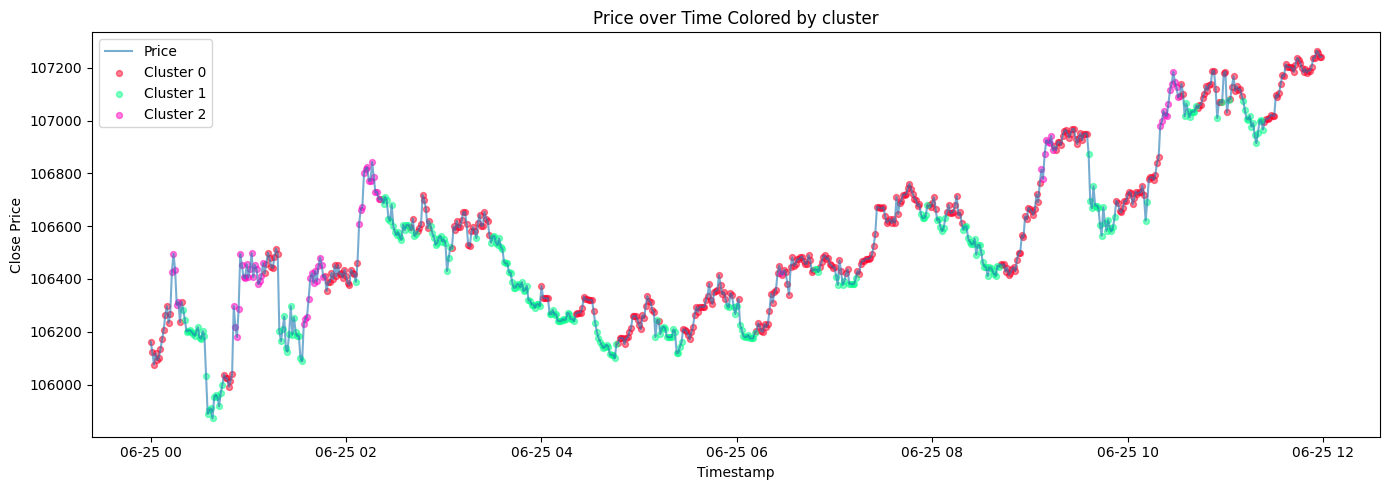

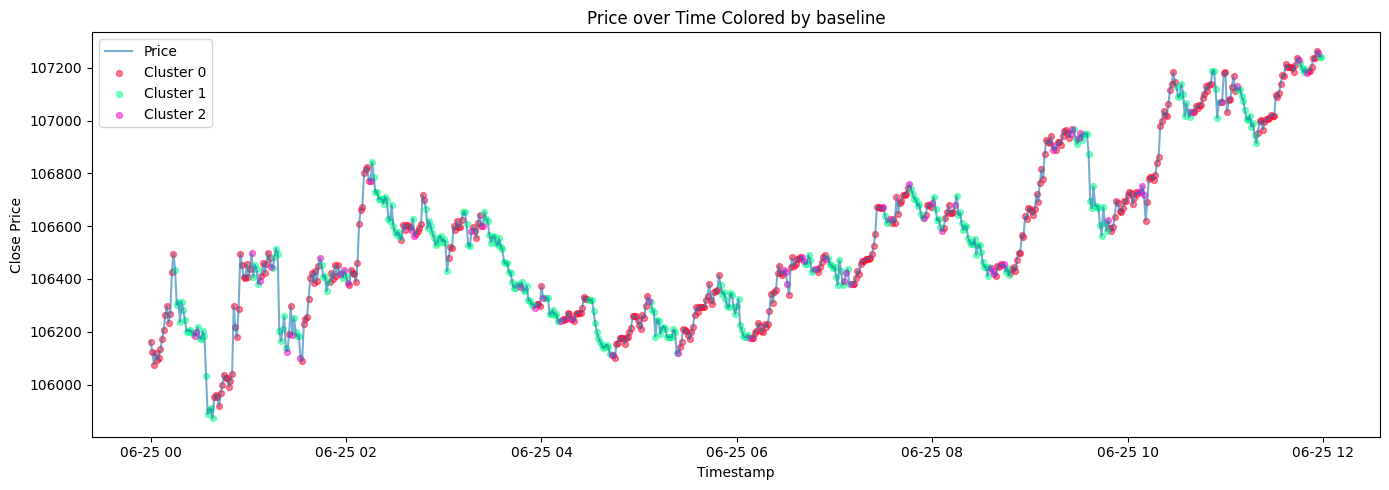

In [13]:
t , T = 1440 * 6 , 720
plot_fn(df2[-t:-t+T], 'cluster')
plot_fn(df2[-t:-t+T], 'baseline')

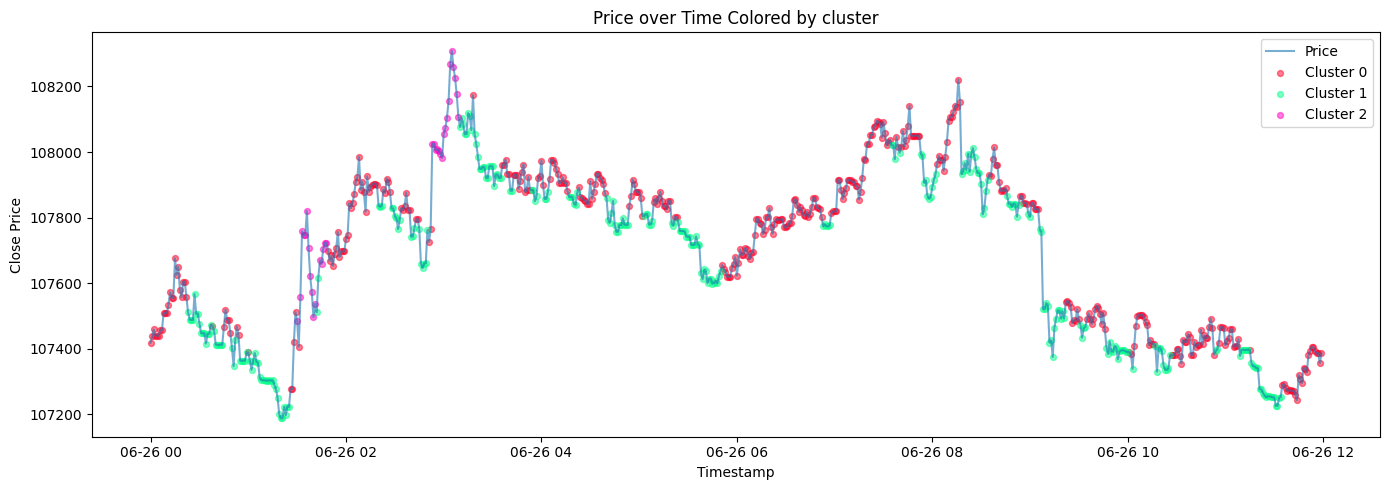

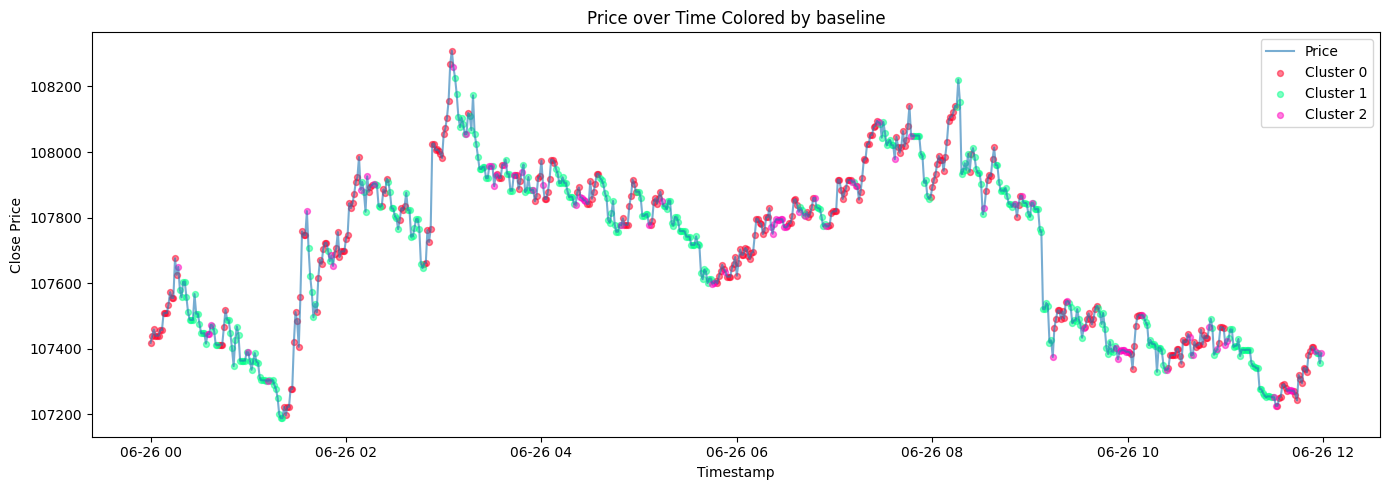

In [14]:
t , T = 1440 * 5 , 720
plot_fn(df2[-t:-t+T], 'cluster')
plot_fn(df2[-t:-t+T], 'baseline')

we can rely on the clusters to predict the uptrends and the downtrends

## Backtesting the original oracle

Logic :
- Using the Oracle's Predictions, we obtain the ideal position we should take.
- We smooth it over past 3 timeframes and execute an order to achieve this position.

In [15]:
def simulate_smooth_position_pnl(df, position_col="position", price_col="price", initial_cash=None, smoothing=3):
    # Smooth the position signal
    smoothed_position = df[position_col].rolling(smoothing, min_periods=1).mean()

    # Compute position delta (change in position)
    delta_position = smoothed_position.diff().fillna(0)

    # Use the first price as base
    if initial_cash is None:
        initial_cash = df[price_col].iloc[0]

    # Cash update: sell = cash increases, buy = cash decreases
    cash = initial_cash - np.cumsum(delta_position * df[price_col])

    # Mark to market portfolio value
    mark_to_market = cash + smoothed_position * df[price_col]

    # Add columns to df
    df["smoothed_position"] = smoothed_position
    df["delta_position"] = delta_position
    df["cash"] = cash
    df["mark_to_market"] = mark_to_market

    return df

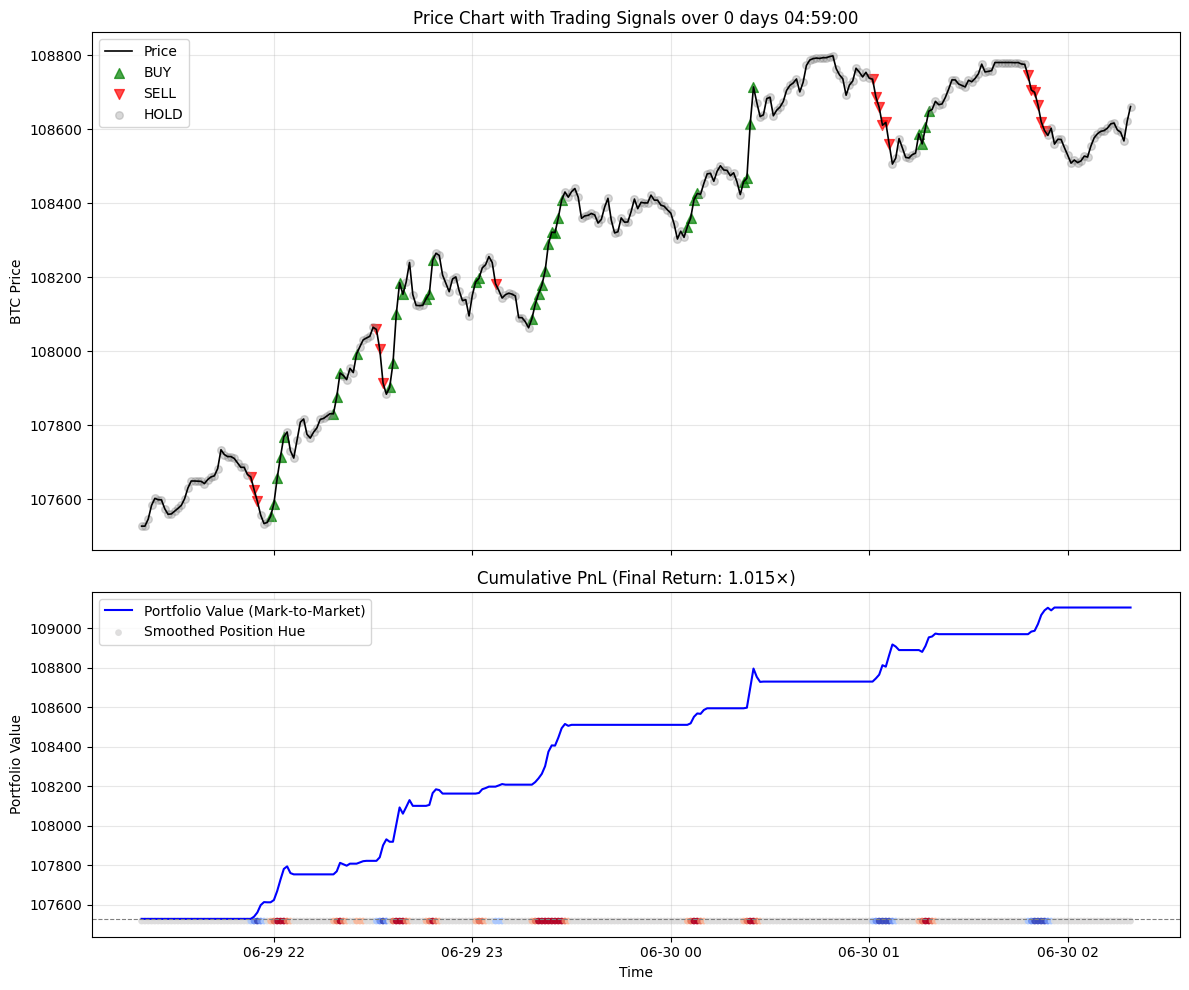

Final strategy multiplier: 1.0147×


In [16]:
def plot_smooth_target_vs_price(df, horizon=5, buy_thresh=np.log(1.0007), sell_thresh=np.log(1.0007), smoothing_window=3):
    df = df.copy()

    df.sort_values("Timestamp", inplace=True)
    df["target"] = np.log(df["price"].shift(-horizon).rolling(horizon).mean() / df["price"].shift(1))
    df["target"] = df["target"].rolling(smoothing_window).mean()
    df["position"] = np.where(df["target"] > buy_thresh, 1,
                       np.where(df["target"] < -sell_thresh, -1, 0))
    # Backtest with smoothed positions
    df = simulate_smooth_position_pnl(df,smoothing=smoothing_window)

    final_value = df["mark_to_market"].iloc[-1]
    final_multiplier = final_value / df["cash"].iloc[0]

    buy = df[df["position"] == 1]
    sell = df[df["position"] == -1]
    hold = df[df["position"] == 0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 2]})

    sizes = ([50,30,0.3]) if(df.iloc[-1]['Timestamp']-df.iloc[0]['Timestamp'] < pd.Timedelta(days=1)) else([18,5,0.1])
    # Price chart
    ax1.plot(df["Timestamp"], df["price"], color="black", linewidth=1.2, label="Price")
    ax1.scatter(buy["Timestamp"], buy["price"], color="green", marker="^", s=sizes[0], alpha=0.7, label="BUY")
    ax1.scatter(sell["Timestamp"], sell["price"], color="red", marker="v", s=sizes[0], alpha=0.7, label="SELL")
    ax1.scatter(hold["Timestamp"], hold["price"], color="grey", marker="o", s=sizes[1], alpha=sizes[2], label="HOLD")
    ax1.set_ylabel("BTC Price")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title(f"Price Chart with Trading Signals over {df.iloc[-1]['Timestamp']-df.iloc[0]['Timestamp']}")

    # Portfolio Value chart
    # df["portfolio_returns"] = df["mark_to_market"]/df["price"].iloc[0]
    ax2.plot(df["Timestamp"], df["mark_to_market"], color="blue", label="Portfolio Value (Mark-to-Market)")
    price_floor = df["mark_to_market"].min() - 0.0001 * df["mark_to_market"].max()
    hue_y = [price_floor] * len(df)
    cmap = plt.get_cmap("coolwarm")
    colors = cmap(plt.Normalize(-1, 1)(df["smoothed_position"]))
    ax2.scatter(df["Timestamp"], hue_y, color=colors, s=15, alpha=0.9, label="Smoothed Position Hue")
    ax2.axhline(df["cash"].iloc[0], linestyle="--", color="gray", linewidth=0.8)
    ax2.set_title(f"Cumulative PnL (Final Return: {final_multiplier:.3f}×)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Portfolio Value")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper left")

    plt.tight_layout()
    plt.show()
    print(f"Final strategy multiplier: {final_multiplier:.4f}×")

t = 1600
df2 = df.iloc[-t:-t+300].copy()
plot_smooth_target_vs_price(df2, horizon=5, buy_thresh=np.log(1.0007), sell_thresh=np.log(1.0007))

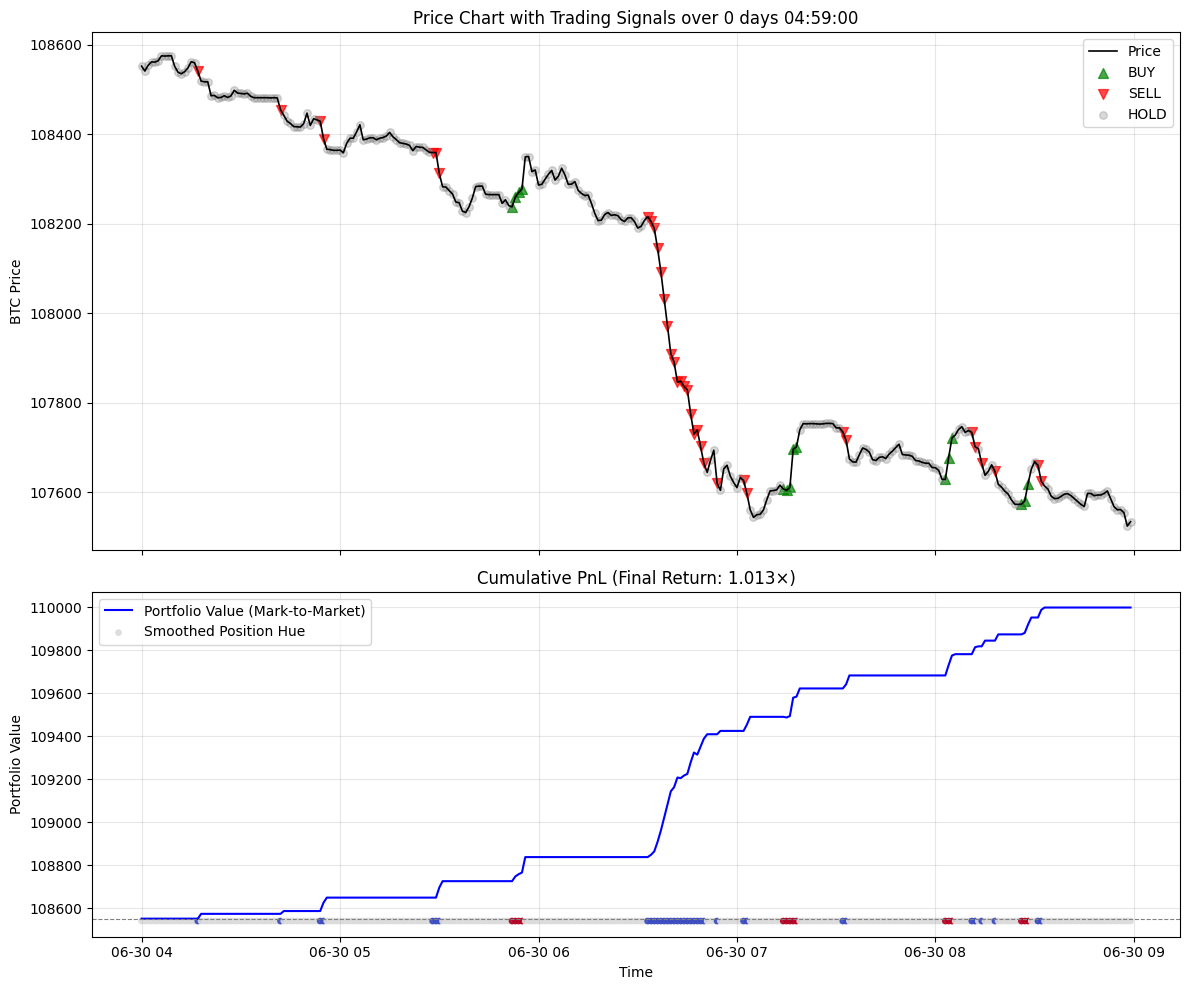

Final strategy multiplier: 1.0133×


In [17]:
t = 1200 # > 250
df2 = df.iloc[-t:-t+300].copy()
plot_smooth_target_vs_price(df2, horizon = 5, buy_thresh = np.log(1.0005), sell_thresh = np.log(1.0005),smoothing_window=1)

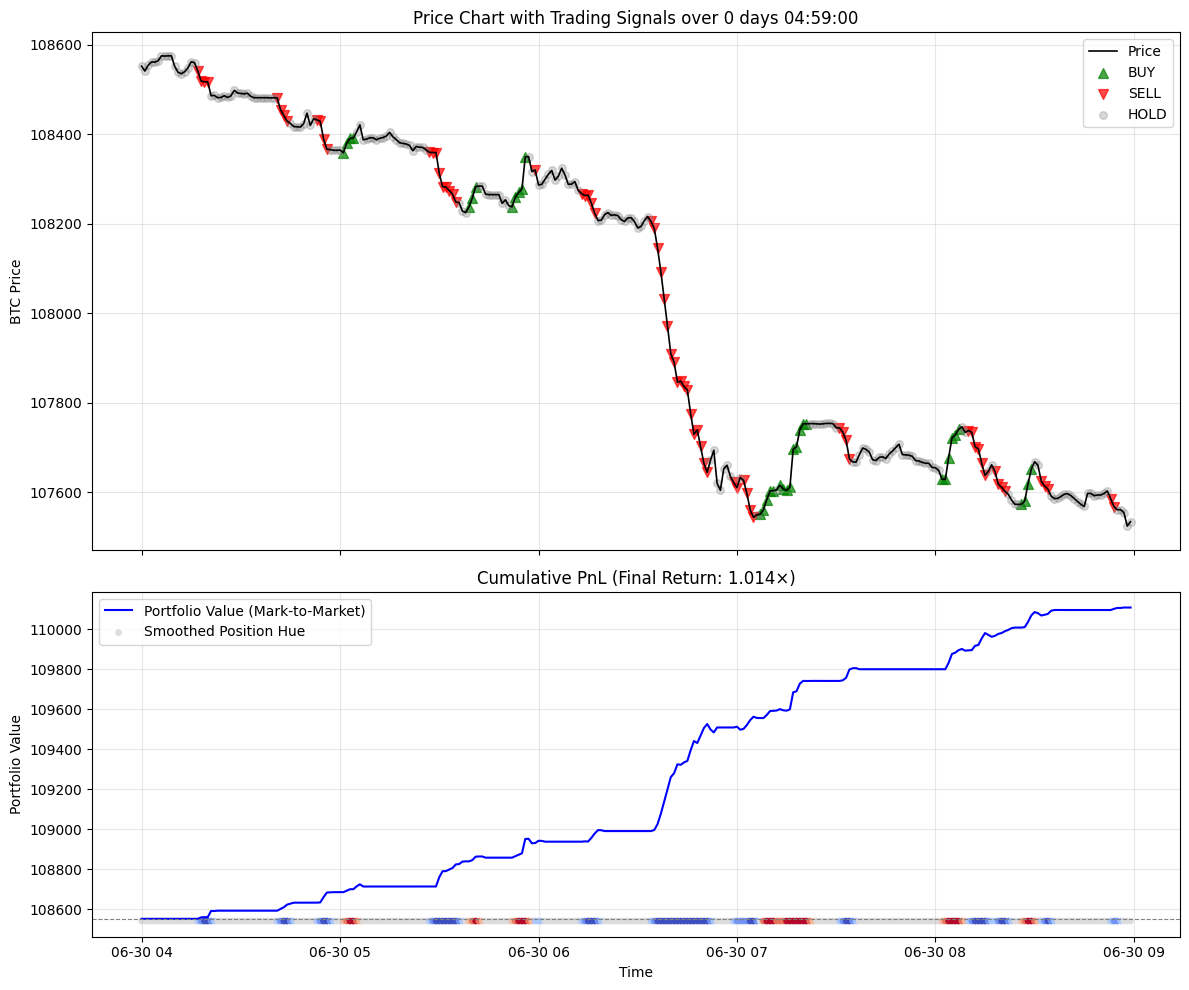

Final strategy multiplier: 1.0143×


In [18]:
t = 1200 # > 250
df2 = df.iloc[-t:-t+300].copy()
plot_smooth_target_vs_price(df2, horizon = 5, buy_thresh = np.log(1.0002), sell_thresh = np.log(1.0003))

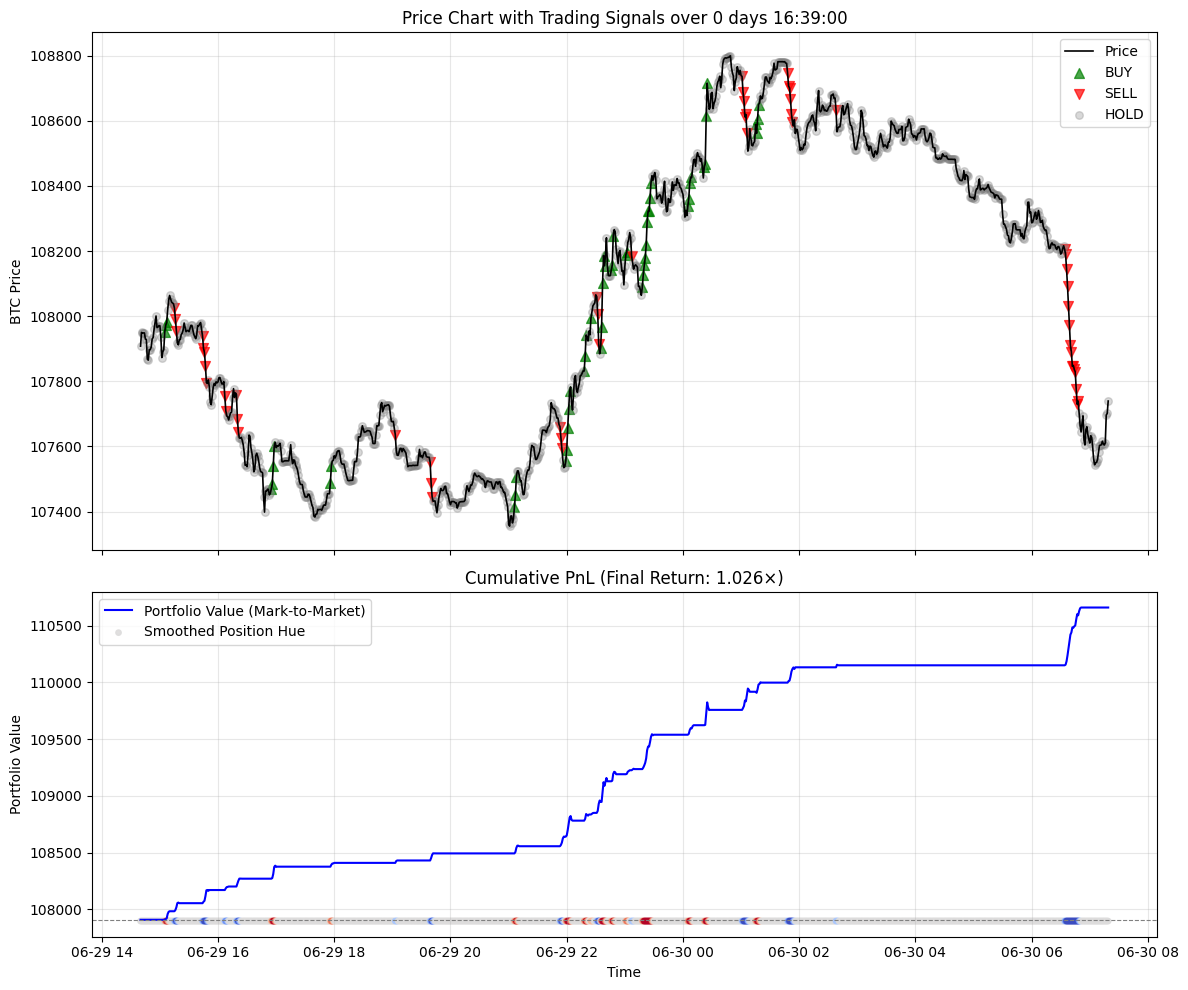

Final strategy multiplier: 1.0255×


In [19]:
t = 2000
df2 = df.iloc[-t:-t+1000].copy()
plot_smooth_target_vs_price(df2, horizon=5, buy_thresh=np.log(1.0007), sell_thresh=np.log(1.0007))

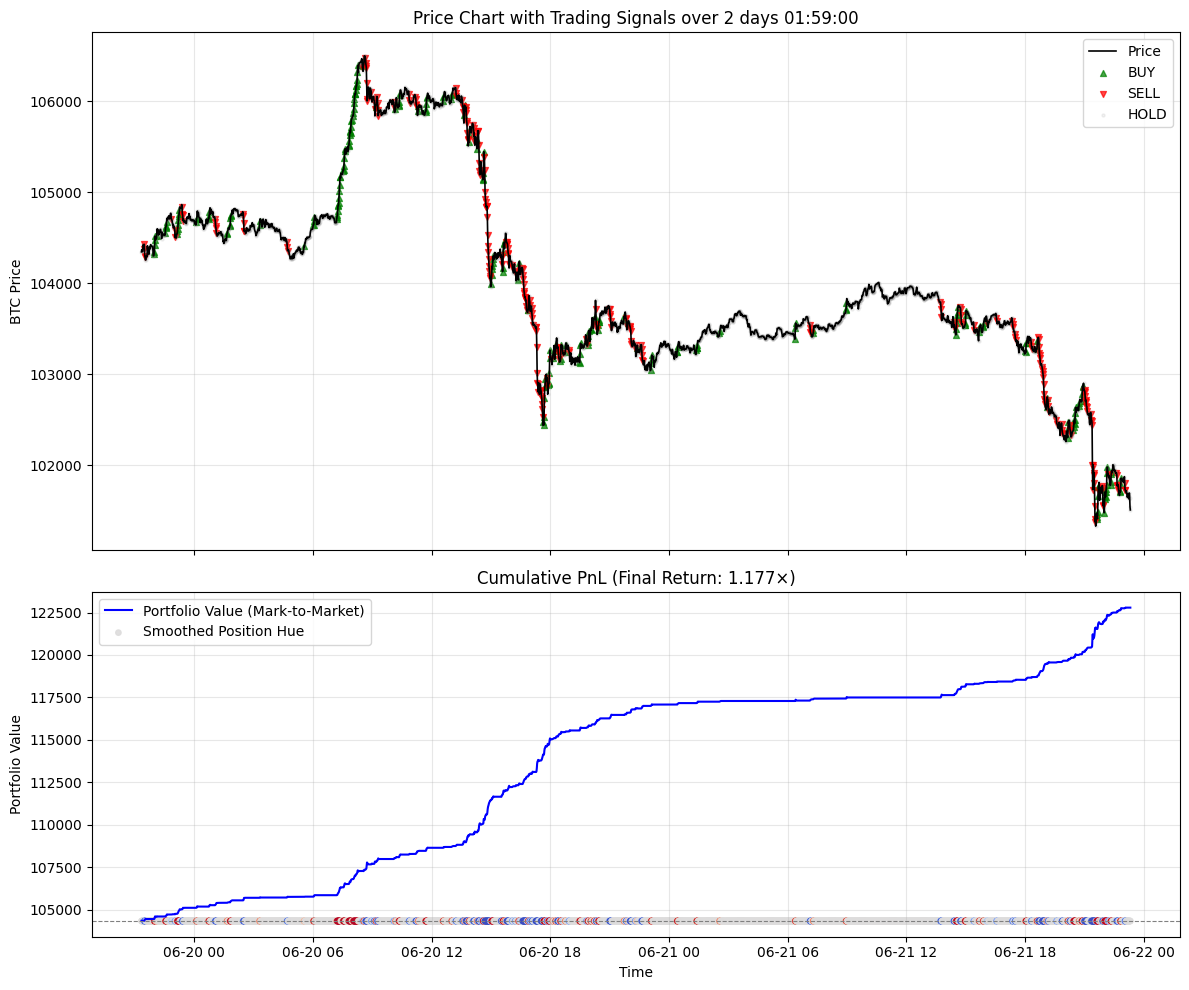

Final strategy multiplier: 1.1767×


In [20]:
t = 16000 # > 250
df2 = df.iloc[-t:-t+3000].copy()
plot_smooth_target_vs_price(df2, horizon = 5, buy_thresh = np.log(1.0007), sell_thresh = np.log(1.0007))

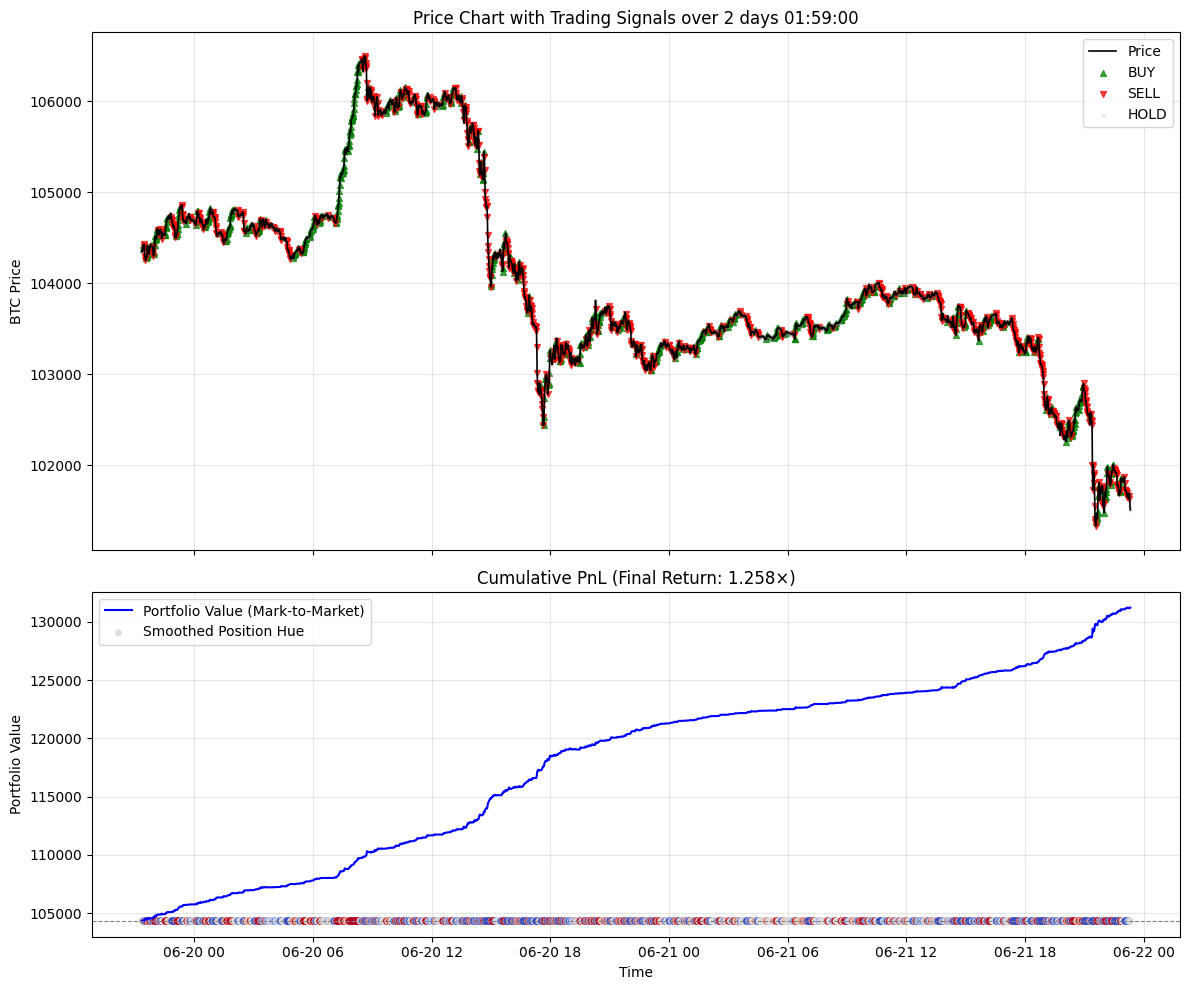

Final strategy multiplier: 1.2577×


In [21]:
t = 16000 # > 250
df2 = df.iloc[-t:-t+3000].copy()
plot_smooth_target_vs_price(df2, horizon = 4, buy_thresh = np.log(1.0002), sell_thresh = np.log(1.0002))

In [22]:
from scipy.stats import zscore
from datetime import timedelta

def evaluate_strategy(df_full, horizon=5,
                      buy_thresh=np.log(1.0007), sell_thresh=np.log(1.0007),
                      backtest_days=2,
                      smoothing_window=3,
                      price_col="price",
                      cluster_col="cluster",
                      timestamp_col="Timestamp"):
    df_full = df_full.copy()
    df_full = df_full.sort_values(timestamp_col)

    # Select a random 2-day window
    df_full[timestamp_col] = pd.to_datetime(df_full[timestamp_col])
    min_time = df_full[timestamp_col].min()
    max_time = df_full[timestamp_col].max() - timedelta(days=backtest_days)

    random_start = min_time + timedelta(seconds=np.random.randint(0, int((max_time - min_time).total_seconds())))
    random_end = random_start + timedelta(days=backtest_days)
    df = df_full[(df_full[timestamp_col] >= random_start) & (df_full[timestamp_col] <= random_end)].copy()

    if len(df) < 100:
        return None  # skip tiny fragments

    df["target"] = np.log(df["price"].shift(-horizon).rolling(horizon).mean() / df["price"].shift(1))
    df["target"] = df["target"].rolling(smoothing_window).mean()
    df["position"] = np.where(df["target"] > buy_thresh, 1,
                       np.where(df["target"] < -sell_thresh, -1, 0))

    # Backtest with smoothed positions
    df = simulate_smooth_position_pnl(df, smoothing=smoothing_window)

    final_value = df["mark_to_market"].iloc[-1]
    final_multiplier = final_value / df["cash"].iloc[0]

    # Calculate hourly returns for Sharpe
    df = df.set_index(timestamp_col)
    df.index = pd.to_datetime(df.index)
    portfolio_hourly = df["mark_to_market"].resample("1h").last().dropna()
    hourly_returns = portfolio_hourly.pct_change().dropna()

    # Compute metrics
    final_value = df["mark_to_market"].iloc[-1]
    sharpe = (hourly_returns.mean() / hourly_returns.std()) * np.sqrt(24) if len(hourly_returns) > 1 else 0

    return {
        "final_value": final_value,
        "sharpe_hourly": sharpe,
        "start_time": random_start,
        "end_time": random_end,
        "multiplier": final_multiplier,
        "num_points": len(df)
    }

results = evaluate_strategy(dfC, horizon=5,
                            buy_thresh=np.log(1.0007), sell_thresh=np.log(1.0007),
                            backtest_days=2,
                            smoothing_window=3)

if results:
    print(f"Final portfolio value: ₹{results['final_value']:.2f}")
    print(f"Return multiplier: {results['multiplier']:.3f}×")
    print(f"Sharpe (hourly): {results['sharpe_hourly']:.3f}")
    print(f"Evaluated on {results['num_points']} points from {results['start_time']} to {results['end_time']}")
else:
    print("Random window too small — skipped.")

Final portfolio value: ₹126214.33
Return multiplier: 1.205×
Sharpe (hourly): 5.775
Evaluated on 2880 points from 2025-06-17 20:07:18+00:00 to 2025-06-19 20:07:18+00:00


In [23]:
results = evaluate_strategy(dfC, horizon=5,
                            buy_thresh=np.log(1.0007), sell_thresh=np.log(1.0007),
                            backtest_days=2,
                            smoothing_window=3)

if results:
    print(f"Final portfolio value: ${results['final_value']:.2f}")
    print(f"Return multiplier: {results['multiplier']:.3f}×")
    print(f"Sharpe (hourly): {results['sharpe_hourly']:.3f}")
    print(f"Evaluated on {results['num_points']} points from {results['start_time']} to {results['end_time']}")
else:
    print("Random window too small — skipped.")

Final portfolio value: $128237.83
Return multiplier: 1.215×
Sharpe (hourly): 4.139
Evaluated on 2880 points from 2025-06-04 09:04:50+00:00 to 2025-06-06 09:04:50+00:00


In [24]:
results = evaluate_strategy(dfC, horizon=9,
                            buy_thresh=np.log(1.0003), sell_thresh=np.log(1.0006),
                            backtest_days=2, smoothing_window=3)

if results:
    print(f"Final portfolio value: ${results['final_value']:.2f}")
    print(f"Return multiplier: {results['multiplier']:.3f}×")
    print(f"Sharpe (hourly): {results['sharpe_hourly']:.3f}")
    print(f"Evaluated on {results['num_points']} points from {results['start_time']} to {results['end_time']}")
else:
    print("Random window too small — skipped.")

Final portfolio value: $134397.83
Return multiplier: 1.261×
Sharpe (hourly): 7.383
Evaluated on 2880 points from 2025-06-25 09:51:19+00:00 to 2025-06-27 09:51:19+00:00


let's confirm :

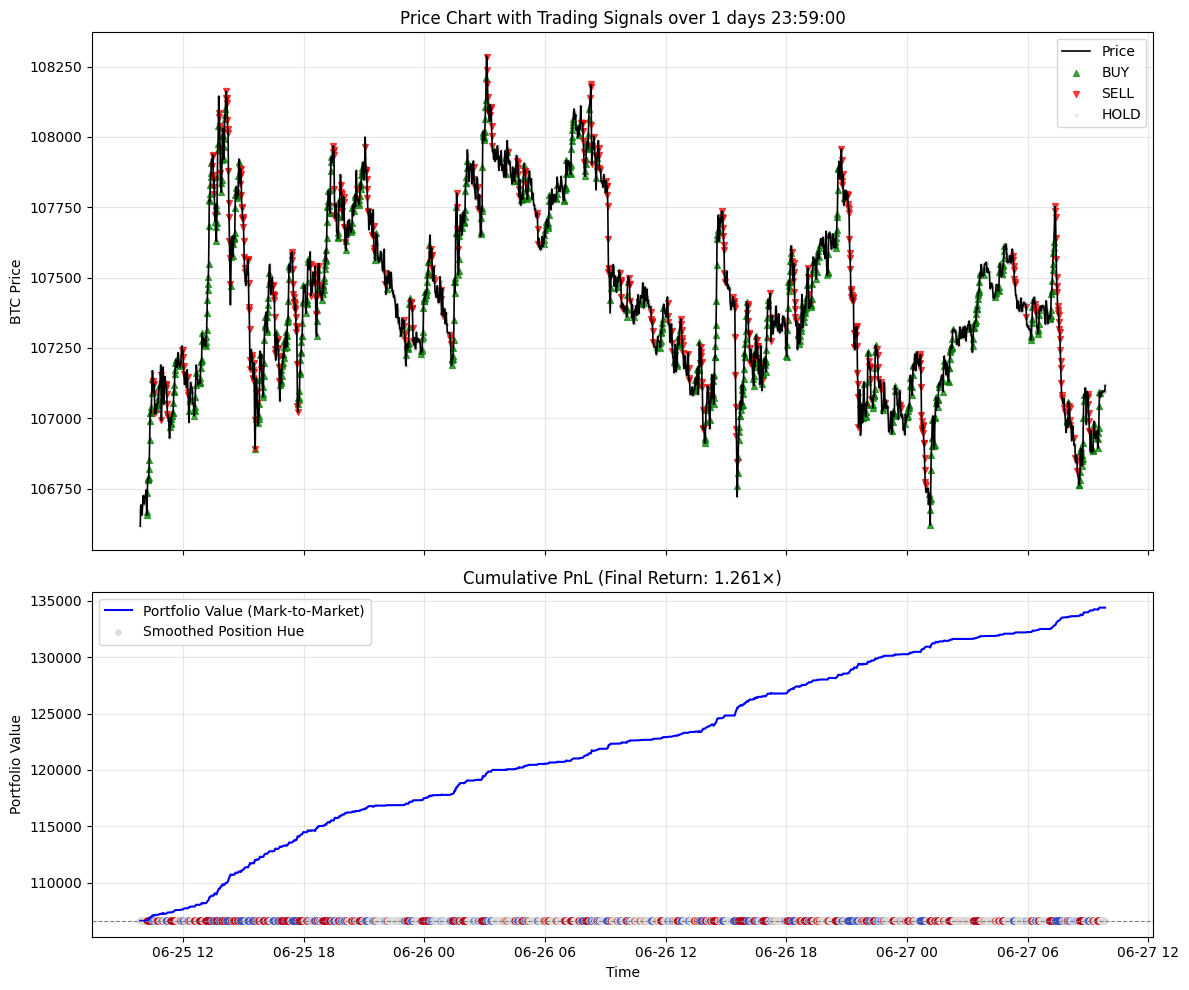

Final strategy multiplier: 1.2606×


In [25]:
df2 = dfC[(dfC['Timestamp'] >= results['start_time']) &
          (dfC['Timestamp'] <= results['end_time'])].copy()
plot_smooth_target_vs_price(df2, horizon = 9, buy_thresh = np.log(1.0003), sell_thresh = np.log(1.0006))

In [26]:
import optuna
from optuna.pruners import MedianPruner

def objective(trial):
    # --- Suggest hyperparameters ---
    horizon = trial.suggest_int("horizon", 3, 20)
    buy_thresh = trial.suggest_float("buy_thresh", 0.1, 20, log=True)
    sell_thresh = trial.suggest_float("sell_thresh", 0.1, 20, log=True)
    smoothing_window = trial.suggest_int("smoothing_window", 1, 10)

    # --- Store scores over multiple seeds ---
    scores = []
    for i in range(10):
        result = evaluate_strategy(
            dfC.copy(),
            backtest_days=2,
            smoothing_window=smoothing_window,
            horizon=horizon,
            buy_thresh=np.log(1 + buy_thresh / 10000),
            sell_thresh=np.log(1 + sell_thresh / 10000),
        )

        if result is None:
            continue  # skip empty windows

        score = result['sharpe_hourly']/1000 + result['multiplier']
        scores.append(score)

        trial.report(score, i)
        if trial.should_prune():
            raise optuna.TrialPruned()

    if not scores:
        return float('-inf')

    return np.mean(scores)

In [27]:
pruner = MedianPruner(n_warmup_steps=5)

study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("Best trial:")
print(study.best_trial.params)

[I 2025-07-15 04:41:35,172] A new study created in memory with name: no-name-47283b59-a23c-4801-851d-727aefabcc67


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-07-15 04:41:35,599] Trial 0 finished with value: 1.268022990037301 and parameters: {'horizon': 13, 'buy_thresh': 5.296112673974845, 'sell_thresh': 0.41810576767458213, 'smoothing_window': 3}. Best is trial 0 with value: 1.268022990037301.
[I 2025-07-15 04:41:35,971] Trial 1 finished with value: 1.2469385719255788 and parameters: {'horizon': 11, 'buy_thresh': 0.6767425058583634, 'sell_thresh': 12.326343250657652, 'smoothing_window': 2}. Best is trial 0 with value: 1.268022990037301.
[I 2025-07-15 04:41:36,373] Trial 2 finished with value: 1.1023281497484219 and parameters: {'horizon': 19, 'buy_thresh': 17.965925162841298, 'sell_thresh': 0.12760729670125925, 'smoothing_window': 10}. Best is trial 0 with value: 1.268022990037301.
[I 2025-07-15 04:41:36,763] Trial 3 finished with value: 1.0512193087134638 and parameters: {'horizon': 6, 'buy_thresh': 8.204118523116355, 'sell_thresh': 5.590876858811977, 'smoothing_window': 8}. Best is trial 0 with value: 1.268022990037301.
[I 2025-07

In [28]:
import optuna.visualization as vis

In [29]:
vis.plot_optimization_history(study)

In [30]:
vis.plot_param_importances(study)

In [31]:
best_params = study.best_trial.params

horizon = best_params['horizon']
buy_threshh = np.log(1 + best_params['buy_thresh'] / 10000)
sell_threshh = np.log(1 + best_params['sell_thresh'] / 10000)
smoothing_window = best_params['smoothing_window']

In [32]:
horizon , best_params['buy_thresh'] , best_params['sell_thresh'] , smoothing_window

(3, 0.2320020042452706, 0.21332346544093284, 1)

## NOTE : these vales are taken to train the supervised model

In [33]:
result = evaluate_strategy(dfC, horizon=horizon,
                            buy_thresh=buy_threshh, sell_thresh=sell_threshh,
                            backtest_days=2, smoothing_window=smoothing_window)

if result:
    print(f"Final portfolio value: ${result['final_value']:.2f}")
    print(f"Return multiplier: {result['multiplier']:.3f}×")
    print(f"Sharpe (hourly): {result['sharpe_hourly']:.3f}")
    print(f"Evaluated on {result['num_points']} points from {result['start_time']} to {result['end_time']}")
else:
    print("Random window too small — skipped.")

Final portfolio value: $157313.00
Return multiplier: 1.503×
Sharpe (hourly): 15.002
Evaluated on 2880 points from 2025-06-01 05:25:49+00:00 to 2025-06-03 05:25:49+00:00


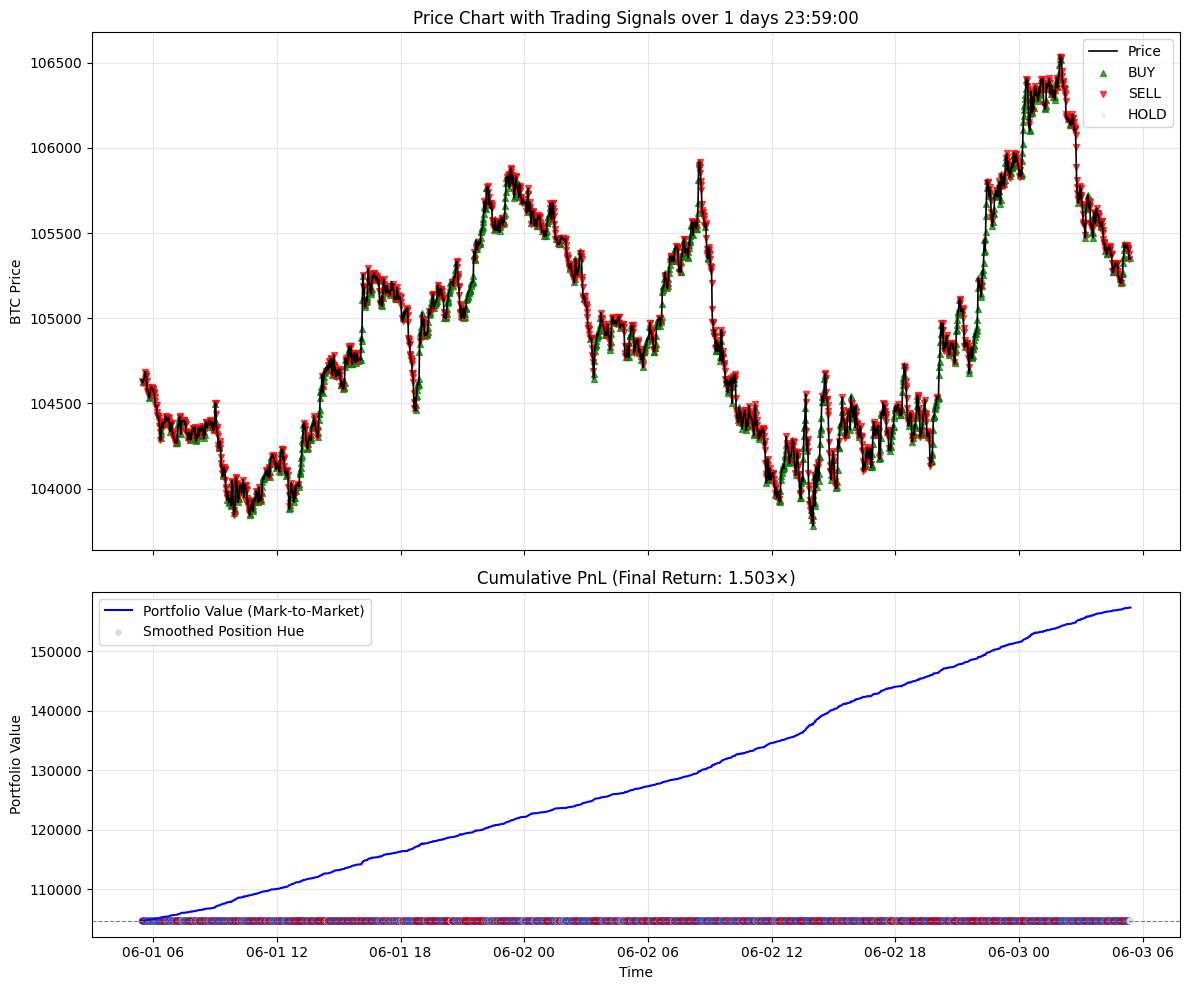

Final strategy multiplier: 1.5034×


In [34]:
df2 = dfC[(dfC['Timestamp'] >= result['start_time']) &
          (dfC['Timestamp'] <= result['end_time'])].copy()
plot_smooth_target_vs_price(df2, horizon = horizon, buy_thresh = buy_threshh, sell_thresh = sell_threshh,smoothing_window=smoothing_window)

In [35]:
import json

# Collect all hyperparameters in a dictionary
params_to_save = {
    'horizon': horizon,
    'buy_thresh': best_params['buy_thresh'],
    'sell_thresh': best_params['sell_thresh'],
    'smoothing_window': smoothing_window
}

# Dump to JSON file
with open('best_hyperparams.json', 'w') as f:
    json.dump(params_to_save, f, indent=4)

print("Saved to best_hyperparams.json")

Saved to best_hyperparams.json
